# Macaque MAPseq Analysis Notebook

Below are all the scripts used to generate the figures for the manuscript **Single basolateral amygdala neurons in macaques exhibit distinct connectional motifs with frontal cortex** by Zeisler *et al* (2023), *Neuron*.

## Imports: packages, data

In [1]:
# Import packages

from filter_funcs import normBCmat2

import numpy as np
import scipy.io as spio
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3, venn3_circles
from venn import venn4
import seaborn as sns
from collections import Counter
import pandas as pd
from sklearn.cluster import KMeans
from scipy.stats import binomtest
from statsmodels.stats.multitest import fdrcorrection
from adjustText import adjust_text
import matplotlib.colors as colors
import random

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.style.use('seaborn')

class MidpointNormalize(colors.Normalize):
	"""
	Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

	e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
	"""
	def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
		self.midpoint = midpoint
		colors.Normalize.__init__(self, vmin, vmax, clip)

	def __call__(self, value, clip=None):
		# I'm ignoring masked values and all kinds of edge cases to make a
		# simple example...
		x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
		return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

rng = np.random.default_rng(11061996)


In [2]:
# Import data

all_combined = np.loadtxt('all_combined.csv',delimiter=',')
all_combined_byanimal = np.loadtxt('all_combined_byanimal.csv',delimiter=',')

areas = ['amygdala','ento','HC','insula','AI','mOFC','lOFC','vlPFC','scACC','pgACC','dACC','PMd','caudate','putamen','NAcc','mdThal','control']
areas2 = ['ento','HC','insula','AI','mOFC','lOFC','vlPFC','scACC','pgACC','dACC','PMd','caudate','putamen','NAcc','mdThal','control']
areas3 = ['amygdala','ento','HC','insula','AI','mOFC','lOFC','vlPFC','scACC','pgACC','dACC','PMd','caudate','putamen','NAcc','mdThal']
areas4 = ['ento','HC','insula','AI','mOFC','lOFC','vlPFC','scACC','pgACC','dACC','PMd','caudate','putamen','NAcc','mdThal']


## Figure 1

MAPseq of macaque BLA

/var/folders/mr/kv4z6yh502l9k00hkqbkrsch0000gn/T/ipykernel_90961/1151589464.py:27: RuntimeWarning: invalid value encountered in double_scalars
  counts.append(('amygdala',avg_amyg/peak_amyg))
/var/folders/mr/kv4z6yh502l9k00hkqbkrsch0000gn/T/ipykernel_90961/1151589464.py:28: RuntimeWarning: invalid value encountered in double_scalars
  counts.append(('targets',avg_target/peak_amyg))
/var/folders/mr/kv4z6yh502l9k00hkqbkrsch0000gn/T/ipykernel_90961/1151589464.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  counts.append(('control',avg_control/peak_amyg))
/Users/zachz/.local/lib/python3.9/site-packages/numpy-1.22.3-py3.9-macosx-10.9-x86_64.egg/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


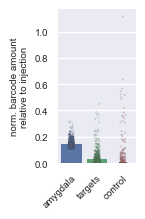

In [3]:
# 1C

mat = spio.loadmat('sorted_barcodematrix2.mat', squeeze_me=True)

ref_barcodes = mat['refbarcodes']
sorted_barcodematrix = mat['sorted_barcodematrix']
spikes = mat['converted_spikes']

sample_space = np.array(range(0,99)).astype(int)

inj_sites = np.array(range(10)).astype(int)
proj_sites = np.setdiff1d(sample_space,inj_sites).astype(int)

B, Bseq, Bnorm = normBCmat2(sorted_barcodematrix,ref_barcodes,20,5,inj_sites,proj_sites,spikes)

B = np.array(B)

counts = []

for neuron in range(len(B)):
    
    peak_amyg = np.max(Bnorm[neuron,0:9])
    avg_amyg = np.mean(Bnorm[neuron,0:9])
    avg_target = np.mean(Bnorm[neuron,10:93])
    avg_control = np.mean(Bnorm[neuron,94:])
    
    counts.append(('amygdala',avg_amyg/peak_amyg))
    counts.append(('targets',avg_target/peak_amyg))
    counts.append(('control',avg_control/peak_amyg))
    
counts = pd.DataFrame(counts,columns=['area','barcode_ratio'])

fig = plt.figure(figsize=(1,2))

g = sns.stripplot(data=counts,x='area',y='barcode_ratio',alpha=0.25,dodge=True,linewidth=0.25,s=1)

g = sns.barplot(data=counts,x='area',y='barcode_ratio',hue='area',dodge=False,order=['amygdala','targets','control'],ci=95)

g.get_legend().remove()

plt.xlabel('')
plt.ylabel('norm. barcode amount\nrelative to injection',fontsize=7)

plt.tick_params(axis='y',labelsize=7)
plt.tick_params(axis='x',rotation=45,labelsize=7)

plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

#plt.savefig("fig1c.pdf")

plt.show()

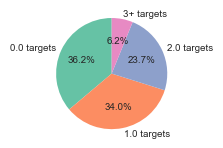

In [4]:
# 1D

n_targets = []

for neuron in range(len(all_combined)):
    
    total_targets = np.sum(all_combined[neuron,:])
    
    total_targets = total_targets - 1
    
    # this will count 0-target neurons as those that stay within amygdala
    
    n_targets.append(total_targets)

counts = Counter(n_targets)

counted = []

for count in counts:
    
    counted.append((count,counts[count]))
    
counted = pd.DataFrame(counted,columns=['n_targets','count'])

counted = counted.sort_values(by='n_targets')

# sns.barplot(data=counted,x='n_targets',y='count')

# plt.xlabel('number of targets')
# plt.ylabel('count neurons')

# plt.show()

# Make pie chart

counted = counted.to_numpy()

plt.figure(figsize=(1.6,1.6))

pie_counts = []

for count in range(len(counted)):
    
    if count <= 2:
    
        pie_counts.append((str(counted[count,0]) + ' targets',counted[count,1]))
        
    elif count == 3:
        
        pie_counts.append(('3+ targets',np.sum(counted[5:,1])))
        
    else:
        
        pass
        
pie_counts = np.vstack(pie_counts)

colors = sns.color_palette('Set2')[0:5]
        
plt.pie(pie_counts[:,1],labels=pie_counts[:,0],colors=colors,startangle=90,autopct='%1.1f%%',textprops={'fontsize':7},labeldistance=1.1)
plt.axis('equal')
#plt.savefig("fig1d.pdf")
plt.show()

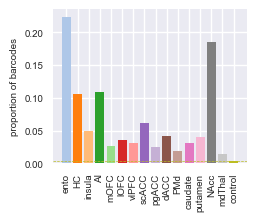

In [5]:
# 1E

collapsed_ = np.sum(all_combined,axis=0)

plt.figure(figsize=(2.5,2))

my_cmap = plt.get_cmap("tab20")

plt.bar(range(len(collapsed_[1:])),collapsed_[1:]/(np.sum(collapsed_[1:])),color=my_cmap.colors[1:])

plt.xticks(range(len(collapsed_[1:])),areas2,rotation=90,fontsize=7)
plt.yticks(fontsize=7)

plt.ylabel('proportion of barcodes',fontsize=7)
plt.xlabel('')

plt.axhline(collapsed_[-1]/np.sum(collapsed_[1:]),linestyle='dashed',linewidth=0.5,color=my_cmap.colors[16])

#plt.savefig("fig1e.pdf")

plt.show()

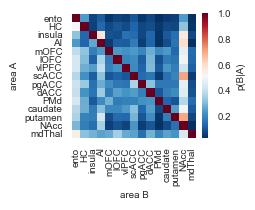

In [6]:
# 1F

no_amy = np.delete(all_combined,[0,16],axis=1) #remove amyg

probs = []

for area1 in range(len(no_amy[0])):
    
    for area2 in range(len(no_amy[0])):
        
        proj_to_area1 = no_amy[np.where(no_amy[:,area1] == 1)]
        
        proj_to_area2 = np.count_nonzero(proj_to_area1[:,area2])
        
        prop_both = proj_to_area2 / len(proj_to_area1)
        
        probs.append(prop_both)
        
probs = np.array(probs).reshape((15,15))

plt.figure(figsize=(1.75,1.75))

fig = plt.imshow(probs,cmap='RdBu_r')
plt.xticks(range(len(probs)),areas4,rotation=90,fontsize=7)
plt.yticks(range(len(probs)),areas4,fontsize=7)

plt.xlabel('area B',fontsize=7)
plt.ylabel('area A',fontsize=7)

plt.grid(False)

cbar = plt.colorbar(fig,fraction=0.046, pad=0.04)

cbar.set_label(label='p(B|A)',size=7)

cbar.ax.tick_params(labelsize=7)

#plt.savefig("fig1f.pdf")

plt.show()

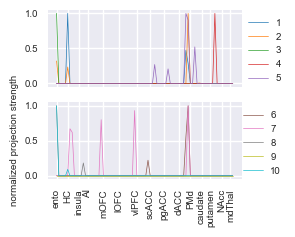

In [7]:
# 1G

labels = np.array([0,1,2,9,5,6,10,7,11,8,12,13,14,4,3,15,16])

mat = spio.loadmat('sorted_barcodematrix3.mat', squeeze_me=True)

ref_barcodes = mat['refbarcodes']
sorted_barcodematrix = mat['sorted_barcodematrix']
spikes = mat['converted_spikes']

sample_space = np.array(range(0,99)).astype(int)

inj_sites = np.array(range(13)).astype(int)
proj_sites = np.setdiff1d(sample_space,inj_sites).astype(int)

B, Bseq, Bnorm = normBCmat2(sorted_barcodematrix,ref_barcodes,20,5,inj_sites,proj_sites,spikes)

Bnorm_norm = []

for neuron in range(len(Bnorm)):
    
    max_strength = np.amax(Bnorm[neuron,13:])
    
    if max_strength == 0:
        
        norm_neuron = Bnorm[neuron,:]
        
    else:
    
        norm_neuron = Bnorm[neuron,:] / max_strength
    
    Bnorm_norm.append(norm_neuron)
    
Bnorm_norm = np.vstack(Bnorm_norm)

# re-sort to follow order in other figures
sort_order = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,99,89,90,91,84,85,86,87,29,30,31,32,33,34,35,36,37,38,39,40,41,42,50,51,52,53,54,55,56,57,63,64,65,66,67,68,23,24,25,26,27,28,43,44,45,46,47,48,49,58,59,60,61,62,69,70,71,72,73,74,75,76,77,78,79,90,81,82,83,92,93,94,95,96,97,98]

to_sort = np.vstack((sort_order,Bnorm_norm))

Bnorm_norm = to_sort[:, to_sort[0, :].argsort()]

Bnorm_norm = np.delete(Bnorm_norm,0,axis=0)

#%%

label = [0,13,18,23,27,34,41,49,55,61,68,73,78,82,87,91,94]

fig, axs = plt.subplots(2,1,figsize=(2.5,2.2),sharex=True,sharey=True)

for barcode in [1,2,3,4,5]:
    
    color = plt.get_cmap('tab10')(barcode-1)
    
    axs[0].plot(Bnorm_norm[barcode,13:93],linewidth=0.5,c=color,label=barcode)
    
    axs[0].set_xticks(np.array(label[1:-1]) - 13)
    axs[0].set_xticklabels(areas[1:-1],rotation=90,fontsize=7)
    
    axs[0].yaxis.set_tick_params(labelsize=7)
    
    axs[0].set_ylabel('',fontsize=7)
    
    axs[0].legend(loc='upper right',bbox_to_anchor=(1.25,1.0),fontsize=7)

for barcode in [6,7,8,9,10]:
    
    color = plt.get_cmap('tab10')(barcode-1)
    
    axs[1].plot(Bnorm_norm[barcode,13:93],linewidth=0.5,c=color,label=barcode)
    
    axs[1].set_xticks(np.array(label[1:-1]) - 13)
    axs[1].set_xticklabels(areas4,rotation=90,fontsize=7)
    
    axs[1].yaxis.set_tick_params(labelsize=7)
    
    axs[1].set_ylabel('normalized projection strength',fontsize=7)
    
    axs[1].legend(loc='upper right',bbox_to_anchor=(1.25,1.0),fontsize=7)
    
#plt.savefig("fig1g.pdf")

plt.show()

## Figure 2

Single neuron analysis of branching projections from BLA

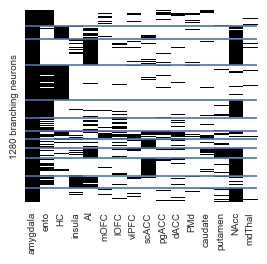

In [8]:
# 2A

collaterals = []

for neuron in range(len(all_combined)):

    if np.sum(all_combined[neuron,:]) > 2:
        
        collaterals.append(all_combined[neuron,:-1])
        
collaterals = np.vstack(collaterals)
collaterals = np.vstack(collaterals)

# wcss=[]
# for i in range(2,30):
#     kmeans = KMeans(n_clusters=i)
#     kmeans.fit(collaterals)
#     wcss_iter = kmeans.inertia_
#     wcss.append(wcss_iter)

# number_clusters = range(2,30)
# plt.plot(number_clusters,wcss)
# plt.title('How many clusters?')
# plt.xlabel('n_clusters')
# plt.ylabel('WCSS')

# plt.show()

# do k means

n_clusters = 12

est = KMeans(n_clusters=n_clusters)

est.fit(abs(collaterals))

labels = est.labels_

# sort neurons according to clustering
    
paired = zip(collaterals,labels)

res = sorted(paired, key = lambda x: x[1]) 

sorted_ = []
sorted_one_color = []
sorted_colors = []

for neuron in range(len(res)):
    
    barcodes = res[neuron][0]
    
    sorted_one_color.append(barcodes)  
      
sorted_one_color = np.vstack(sorted_one_color)
    
# calculate seprating lines positions

from collections import Counter 

count = Counter(labels)

breaks = []

for i in range(n_clusters):
    
    breaks.append(count[i])
    
breakpoints = []

for i in range(n_clusters + 1):
    
    breakpoints.append(np.sum(breaks[:i]))
    
breakpoints = breakpoints[1:]

plt.figure(figsize=(3,2.5))

plt.imshow(sorted_one_color,aspect='auto',cmap='Greys',interpolation='none')

plt.xticks(range(16),areas3,fontsize=7)
plt.xticks(rotation=90)
plt.yticks([])
plt.ylabel('%i branching neurons' %len(sorted_one_color),fontsize=7)

for b in range(len(breakpoints)-1):
    
    plt.axhline(breakpoints[b],color='#4c72b0',linewidth=1.2)

plt.grid(False)

#plt.savefig("fig2a.pdf")

plt.show()

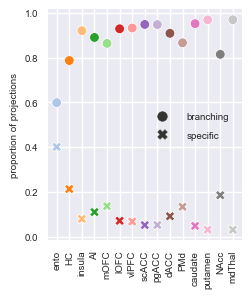

In [9]:
# 2B

single_targets = []

collaterals = []

for neuron in range(len(all_combined)):
    
    count_targets = np.sum(all_combined[neuron,:])
    
    if count_targets == 2:
        
        single_targets.append(all_combined[neuron,:])
        
    elif count_targets >= 3:
        
        collaterals.append(all_combined[neuron,:])

n_single_targets = np.sum(single_targets,axis=0)
n_collaterals= np.sum(collaterals,axis=0)
n_projecting = np.sum(all_combined,axis=0)
target_stats = pd.DataFrame()

target_stats['area'] = areas2
target_stats['n_specific'] = n_single_targets[1:]
target_stats['n_branching'] = n_collaterals[1:]
target_stats['total proj'] = n_single_targets[1:] + n_collaterals[1:]

target_stats['branching'] = target_stats['n_branching']/target_stats['total proj']
target_stats['specific'] = target_stats['n_specific']/target_stats['total proj']

melt = target_stats.melt(id_vars=['area'],value_vars=['specific','branching'])

my_cmap = plt.get_cmap("tab20")


sns.set_palette(sns.color_palette(my_cmap.colors[1:]))

from collections import OrderedDict

plt.figure(figsize=(2.5,3.))

g = sns.scatterplot(data=melt[melt.area!='control'],x='area',y='value',hue='area',style='variable',style_order=['branching','specific'])

plt.xticks(np.array(range(15)),areas4,fontsize=7)
plt.xticks(rotation=90)
plt.yticks(fontsize=7)

plt.xlabel('')
plt.ylabel('proportion of projections',fontsize=7)

leg = g.get_legend()
leg.set_title('')

handles, labels = g.get_legend_handles_labels()
g.legend(handles[-2:], labels[-2:])
plt.setp(g.get_legend().get_texts(), fontsize='7') 

#plt.savefig('Fig2B.pdf')

plt.show()

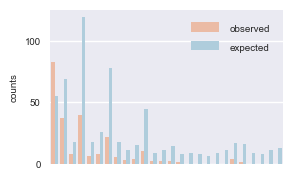

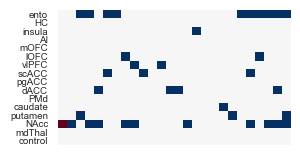

In [10]:
# 2D

obs_exp234 = pd.read_csv('by_hand_obsexp.csv')

# replace with the line below to compare to the null distribution (Supplemental Figure 5)

# obs_exp234 = pd.read_csv('by_hand_obsexp_uniform.csv')

# rearrange data for barplot

#melt = obs_exp234[obs_exp234.n_targets<4].melt(id_vars=['motif','n_targets','pval','effect size'],value_vars=['observed','expected'])
melt = obs_exp234.melt(id_vars=['motif','n_targets','pval','effect size'],value_vars=['observed','expected'])

melt = melt.sort_values(by=['n_targets','effect size'],ascending=[True,False])

melt = melt[melt.pval<0.05]

# melt.replace([np.inf, -np.inf], np.nan, inplace=True)
# melt.dropna(inplace=True)

melt = melt[melt.n_targets<4]

#%% barplot portion

fig = plt.figure(figsize=(3,2))

g = sns.barplot(data=melt,x='motif',y='value',hue='variable',palette='RdBu')

#plt.xticks(rotation=90,fontsize=7)
plt.xticks([])

plt.yticks(fontsize=7)

plt.xlabel('')
plt.ylabel('counts',fontsize=7)

plt.setp(g.get_legend().get_texts(), fontsize='7') 
leg = g.get_legend()
leg.set_title('')

#plt.savefig('Fig2D1.pdf')

plt.show()

motifs = []

for bar in melt.motif.unique():
    
    this_motif = bar
    
    these = melt[melt.motif == this_motif]
    
    effect = these.iloc[0]['effect size']
    
    blank = np.zeros(len(areas2))
    
    for area in range(len(areas2)):
        
        if areas2[area] in this_motif:
            
            if effect > 0:
            
                blank[area] = 1
                
            elif effect < 0:
                
                blank[area] = -1
    
    motifs.append(blank)
    
motifs = np.vstack(motifs)

motifs = motifs.transpose()

plt.figure(figsize=(3,1.75))

plt.imshow(motifs,cmap='RdBu_r',interpolation='none',aspect='auto')

plt.xlabel('')
plt.ylabel('')

plt.xticks([])
plt.yticks(range(len(areas2)),areas2,fontsize=7)

# cbar = plt.colorbar(ticks=[-1,1])
# cbar.ax.set_yticks([1,-1])
# cbar.ax.set_yticklabels(['over-represented','under-represented'],fontsize=7)

plt.grid(False)

#plt.savefig('Fig2D2.pdf')

plt.show()

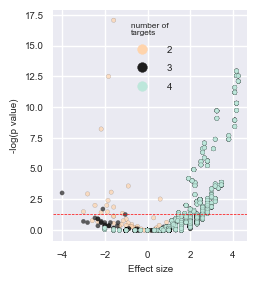

In [11]:
# 2E

plt.figure(figsize=(2.5,3))

g = sns.scatterplot(data=obs_exp234,x='effect size',y='-log(pval)',hue='n_targets',s=10,alpha=0.7,edgecolor='black',linewidth=0.1,palette='icefire_r')

texts = []      
                
# for x, y, l in zip(obs_exp234['effect size'],obs_exp234['-log(pval)'],obs_exp234['motif']):
    
#     if x != np.nan and y != np.nan:
    
#         if y >= -1*np.log10(0.05):
    
#             texts.append(plt.text(x, y, l, size=6))

# adjust_text(texts,arrowprops=dict(arrowstyle='->', color='black'))

plt.axhline(-1*np.log10(0.05),color='red',linestyle='dashed',linewidth=0.5)

g.set_xlabel('Effect size',size=7)
g.set_ylabel('-log(p value)', size=7)

g.tick_params(axis='both', which='major', labelsize=7)

plt.setp(g.get_legend().get_texts(), fontsize='7') 
leg = g.get_legend()
leg.set_title('number of\ntargets')

leg.get_title().set_fontsize('6')

#plt.savefig('Fig2E')

plt.show()

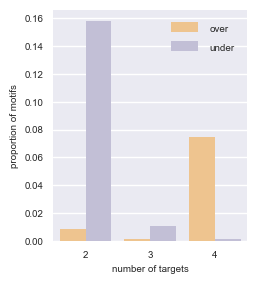

In [12]:
# 2F

sigs = []

for target in obs_exp234.n_targets.unique():
    
    this_n = obs_exp234[obs_exp234.n_targets==target]
    
    sig = this_n[this_n.pval <= 0.05]
    
    prop_over = len(sig[sig['effect size'] > 0]) / len(this_n)
    prop_under = len(sig[sig['effect size'] < 0]) / len(this_n)
    
    if prop_over == 0:
        
        prop_over = 0.001
        
    if prop_under == 0:
        
        prop_under = 0.001

    sigs.append((target,'over',prop_over))
    sigs.append((target,'under',prop_under))

    
sigs = pd.DataFrame(sigs,columns=['n_targets','over_under','prop'])

#%%

pal = sns.mpl_palette("PuOr", 2)

plt.figure(figsize=(2.5,3))

g = sns.barplot(data=sigs[sigs.n_targets<5],x='n_targets',y='prop',hue='over_under',palette=pal)

plt.setp(g.get_legend().get_texts(),fontsize=7) 
leg = g.get_legend()
leg.set_title('')

plt.ylabel('proportion of motifs',fontsize=7)

plt.xlabel('number of targets',fontsize=7)

g.tick_params(axis='both', which='major', labelsize=7)

#plt.savefig('Fig2F.pdf')

plt.show()

## Figure 3

BLA specific projections to medial frontal cortex

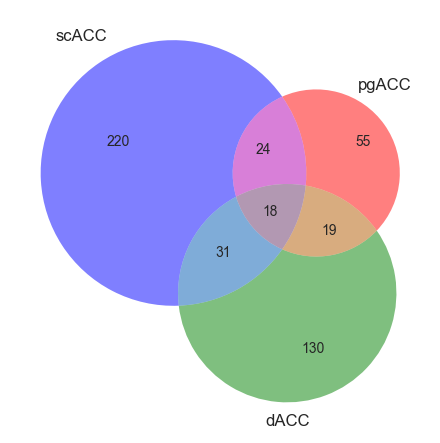

In [13]:
# 3B

sc_only = 0
pg_only = 0
d_only = 0

sc_pg = 0
sc_d = 0
pg_d = 0

all_3 = 0

for neuron in range(len(all_combined)):
    
    if all_combined[neuron,8] == 1 and all_combined[neuron,9] == 0 and all_combined[neuron,10] == 0:
        
        sc_only +=1
        
    elif all_combined[neuron,8] == 0 and all_combined[neuron,9] == 1 and all_combined[neuron,10] == 0:
        
        pg_only +=1
        
    elif all_combined[neuron,8] == 0 and all_combined[neuron,9] == 0 and all_combined[neuron,10] == 1:
        
        d_only +=1
        
    elif all_combined[neuron,8] == 1 and all_combined[neuron,9] == 1 and all_combined[neuron,10] == 0:
        
        sc_pg +=1
        
    elif all_combined[neuron,8] == 1 and all_combined[neuron,9] == 0 and all_combined[neuron,10] == 1:
        
        sc_d +=1
        
    elif all_combined[neuron,8] == 0 and all_combined[neuron,9] == 1 and all_combined[neuron,10] == 1:
        
        pg_d +=1
        
    elif all_combined[neuron,8] == 1 and all_combined[neuron,9] == 1 and all_combined[neuron,10] == 1:
        
        all_3 +=1

venn3(subsets = (sc_only, pg_only, sc_pg, d_only, sc_d, pg_d, all_3), set_labels = ('scACC', 'pgACC', 'dACC'), alpha = 0.5,set_colors=('blue','red','green'))

# colors changed by hand in illustrator

#plt.savefig('Fig3B.pdf')

plt.show()

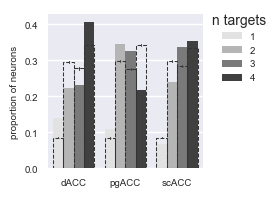

In [14]:
# 3C

sc1 = np.ones(15)
sc2 = np.ones(53) * 2
sc3 = np.ones(74) * 3
sc4 = np.ones(78) * 4

sc = np.hstack((sc1,sc2,sc3,sc4))
sc = pd.DataFrame(sc,columns=['targets'])
sc = sc.assign(area='scACC')
del sc1, sc2, sc3, sc4

pg1 = np.ones(6)
pg2 = np.ones(19) * 2
pg3 = np.ones(18) * 3
pg4 = np.ones(12) * 4

pg = np.hstack((pg1,pg2,pg3,pg4))
pg = pd.DataFrame(pg,columns=['targets'])
pg = pg.assign(area='pgACC')
del pg1, pg2, pg3, pg4

d1 = np.ones(18)
d2 = np.ones(29) *2
d3 = np.ones(30) * 3
d4 = np.ones(53) * 4

d = np.hstack((d1,d2,d3,d4))
d = pd.DataFrame(d,columns=['targets'])
d = d.assign(area='dACC')
del d1, d2, d3, d4

all_acc = pd.concat((sc,pg,d))

iter_res = []

for iter in range(1000):
    
	down_acc = pd.concat((all_acc[all_acc.area=='dACC'].sample(55,replace=False,random_state=1),all_acc[all_acc.area=='pgACC'].sample(55,replace=False,random_state=1),all_acc[all_acc.area=='scACC'].sample(55,replace=False,random_state=1)))
    
	shuf_acc = down_acc.assign(area2 = rng.permutation(down_acc.area.to_numpy()))

	for area in shuf_acc.area2.unique():
		
		this_area = shuf_acc[shuf_acc.area2==area]
		
		for target in [1,2,3,4]:
			
			this_target = this_area[this_area.targets==target]
			
			iter_res.append((area,target,len(this_target),len(this_target)/len(this_area)))
   
res_acc = pd.DataFrame(iter_res,columns=['area','ntargets','count','prop'])
   
iter_res_acc = res_acc.groupby(['area','ntargets'],as_index=False).mean()

real_res_acc = []

for area in all_acc.area.unique():
	
	this_area = all_acc[all_acc.area==area]
	
	for target in [1,2,3,4]:
		
		this_target = this_area[this_area.targets==target]
		
		real_res_acc.append((area,target,len(this_target),len(this_target)/len(this_area)))
  
real_res_acc = pd.DataFrame(real_res_acc,columns=['area','ntargets','count','prop'])

plt.figure(figsize=(2,2))

g=sns.barplot(data=real_res_acc,x='area',y='prop',hue='ntargets',order=['dACC','pgACC','scACC'],palette='Greys')
h=sns.barplot(data=res_acc,x='area',y='prop',hue='ntargets',ci=95,order=['dACC','pgACC','scACC'],facecolor=(1,1,1,0),edgecolor="0.2",linewidth=0.75,linestyle='dashed',errwidth=0.75)

plt.ylabel('proportion of neurons',fontsize=7)
plt.xlabel('')

plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

hand, labl = g.get_legend_handles_labels()
plt.legend(hand[0:4],labl[0:4],title='n targets',fontsize=7,loc='lower left',bbox_to_anchor=(1.0,0.5))

# plt.savefig('Fig3C.pdf')

plt.show()

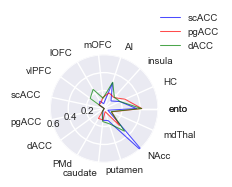

In [15]:
#

no_control = all_combined[:,:-1] # remove control column

proj_to_scacc = []
proj_to_scacc_ = []

for neuron in range(len(all_combined)):
    
    if no_control[neuron,8] == 1 and no_control[neuron,9] == 0 and no_control[neuron,10] == 0:
        
        proj_to_scacc.append(no_control[neuron,:])

proj_to_pgacc = []
proj_to_pgacc_ = []

for neuron in range(len(all_combined)):
    
    if no_control[neuron,8] == 0 and no_control[neuron,9] == 1 and no_control[neuron,10] == 0:
        
        proj_to_pgacc.append(no_control[neuron,:])
        
proj_to_dacc = []
proj_to_dacc_ = []

for neuron in range(len(no_control)):
    
    if no_control[neuron,8] == 0 and no_control[neuron,9] == 0 and no_control[neuron,10] == 1:
        
        proj_to_dacc.append(no_control[neuron,:])
                
props = np.sum(proj_to_scacc,axis=0) / len(proj_to_scacc)

props = props[1:] #remove amygdala

props1 = np.append(props,props[0])

theta = np.linspace(0,1,num=16)

theta = theta * 2 * np.pi

props = np.sum(proj_to_pgacc,axis=0) / len(proj_to_pgacc)

props = props[1:] #remove amygdala

props2 = np.append(props,props[0])

theta = np.linspace(0,1,num=16)

theta = theta * 2 * np.pi

props = np.sum(proj_to_dacc,axis=0) / len(proj_to_dacc)

props = props[1:] #remove amygdala

props3 = np.append(props,props[0])

theta = np.linspace(0,1,num=16)

theta = theta * 2 * np.pi

props1 = np.where(props1 >= 1, 0, props1)
props2 = np.where(props2 >= 1, 0, props2)
props3 = np.where(props3 >= 1, 0, props3)

# make central polar plot

fig,ax = plt.subplots(figsize=(1.4,1.4),subplot_kw={'projection':'polar'})
ax.plot(theta,props1,color='blue',label='scACC',alpha=0.7,linewidth=0.75)
ax.plot(theta,props2,color='red',label='pgACC',alpha=0.7,linewidth=0.75)
ax.plot(theta,props3,color='green',label='dACC',alpha=0.7,linewidth=0.75)


ax.set_rlabel_position(201.25)
ax.set_rgrids([0.2,0.4,0.6],fontsize=7,ha='center')
ax.set_rlim(0,0.6)

ax.set_xticks(theta)
labels = ax.set_xticklabels(areas4 + ['ento'],fontsize=7)
ax.xaxis.set_tick_params(pad=0.5)

for i, label in enumerate(labels):
    if i in [0,1,2,3,13,14,15,16,17]:
        label.set_horizontalalignment('left')
    elif i in [5,6,7,8,9,10,11]:
        label.set_horizontalalignment('right')
    elif i in [4,12]:
        label.set_horizontalalignment('center')
        
angle = np.deg2rad(67.5)
ax.legend(loc="lower left",
          bbox_to_anchor=(0.75 + np.cos(angle)/2, .5 + np.sin(angle)/2),fontsize=7)

#plt.savefig('fig3D')

plt.show()


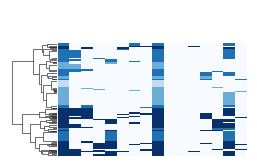

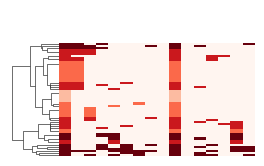

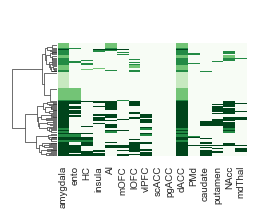

In [16]:
# 3E

proj_to_scacc = np.array(proj_to_scacc)

scacc_specific = []
scacc_2targ = []
scacc_3targ = []
scacc_4plus = []

for neuron in range(len(proj_to_scacc)):
        
    if np.sum(proj_to_scacc[neuron,1:]) == 1:
        
        scacc_specific.append(proj_to_scacc[neuron,:])
        
    elif np.sum(proj_to_scacc[neuron,1:]) == 2:
        
        scacc_2targ.append(proj_to_scacc[neuron,:])
        
    elif np.sum(proj_to_scacc[neuron,1:]) == 3:
        
        scacc_3targ.append(proj_to_scacc[neuron,:])
        
    elif np.sum(proj_to_scacc[neuron,1:]) >= 4:
        
        scacc_4plus.append(proj_to_scacc[neuron,:])
        
scacc_specific = np.array(scacc_specific)
scacc_2targ = np.array(scacc_2targ)
scacc_3targ = np.array(scacc_3targ)
scacc_4plus = np.array(scacc_4plus)
        
scacc_by_target = np.vstack((scacc_specific,scacc_2targ*2,scacc_3targ*3,scacc_4plus*4))


proj_to_pgacc = np.array(proj_to_pgacc)

pgacc_specific = []
pgacc_2targ = []
pgacc_3targ = []
pgacc_4plus = []

for neuron in range(len(proj_to_pgacc)):
        
    if np.sum(proj_to_pgacc[neuron,1:]) == 1:
        
        pgacc_specific.append(proj_to_pgacc[neuron,:])
        
    elif np.sum(proj_to_pgacc[neuron,1:]) == 2:
        
        pgacc_2targ.append(proj_to_pgacc[neuron,:])
        
    elif np.sum(proj_to_pgacc[neuron,1:]) == 3:
        
        pgacc_3targ.append(proj_to_pgacc[neuron,:])
        
    elif np.sum(proj_to_pgacc[neuron,1:]) >= 4:
        
        pgacc_4plus.append(proj_to_pgacc[neuron,:])
        
pgacc_specific = np.array(pgacc_specific)
pgacc_2targ = np.array(pgacc_2targ)
pgacc_3targ = np.array(pgacc_3targ)
pgacc_4plus = np.array(pgacc_4plus)

pgacc_by_target = np.vstack((pgacc_specific,pgacc_2targ*2,pgacc_3targ*3,pgacc_4plus*4))

proj_to_dacc = np.array(proj_to_dacc)

dacc_specific = []
dacc_2targ = []
dacc_3targ = []
dacc_4plus = []

for neuron in range(len(proj_to_dacc)):
        
    if np.sum(proj_to_dacc[neuron,1:]) == 1:
        
        dacc_specific.append(proj_to_dacc[neuron,:])
        
    elif np.sum(proj_to_dacc[neuron,1:]) == 2:
        
        dacc_2targ.append(proj_to_dacc[neuron,:])
        
    elif np.sum(proj_to_dacc[neuron,1:]) == 3:
        
        dacc_3targ.append(proj_to_dacc[neuron,:])
        
    elif np.sum(proj_to_dacc[neuron,1:]) >= 4:
        
        dacc_4plus.append(proj_to_dacc[neuron,:])
        
dacc_specific = np.array(dacc_specific)
dacc_2targ = np.array(dacc_2targ)
dacc_3targ = np.array(dacc_3targ)
dacc_4plus = np.array(dacc_4plus)

dacc_by_target = np.vstack((dacc_specific,dacc_2targ*2,dacc_3targ*3,dacc_4plus*4))

g = sns.clustermap(data=scacc_by_target,cmap='Blues',method='ward',col_cluster=False,figsize=(3,2))

g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticklabels([])

g.cax.set_visible(False)

# plt.savefig('Fig3E1.pdf')

plt.show()

g = sns.clustermap(data=pgacc_by_target,cmap='Reds',method='ward',col_cluster=False,figsize=(3,2))

g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticklabels([])

g.cax.set_visible(False)

# plt.savefig('Fig3E2.pdf')

plt.show()

g = sns.clustermap(data=dacc_by_target,cmap='Greens',method='ward',col_cluster=False,figsize=(3,2))

g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticklabels([])

g.ax_heatmap.set_xticks(np.array(range(16))+0.5)
g.ax_heatmap.set_xticklabels(areas3,rotation=90,fontsize=7)

g.cax.set_visible(False)

# plt.savefig('Fig3E3.pdf')

plt.show()

## Figure 4

BLA specific projections to ventral frontal cortex

/opt/miniconda3/envs/env1/lib/python3.9/site-packages/venn/_backwards_compatibility.py:30: UserWarning: `venn4()` is retained for backwards compatibility; use `venn()` instead
  warn((


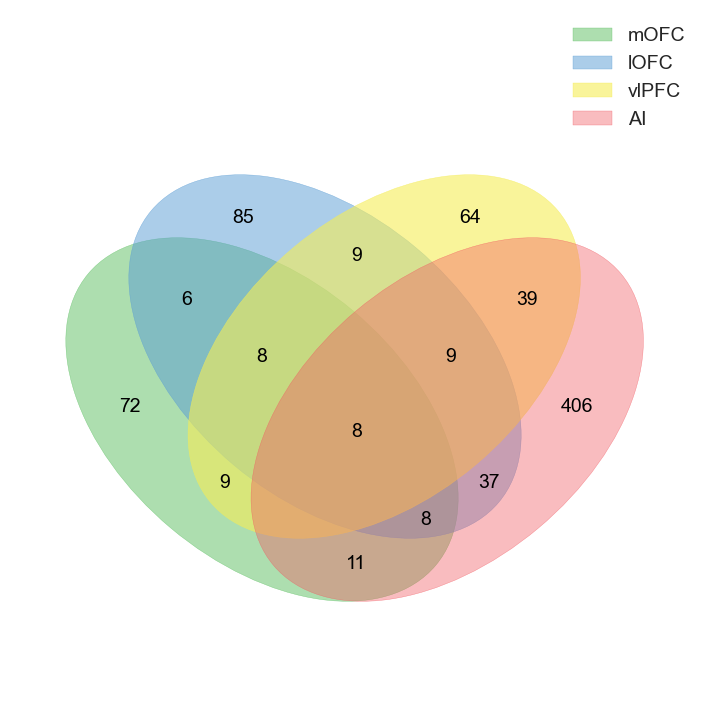

In [17]:
# 4B

m_only = 0
l_only = 0
vl_only = 0
ai_only = 0

m_l = 0
m_vl = 0
m_ai = 0
l_vl = 0
l_ai = 0
vl_ai = 0

m_l_vl = 0
m_l_ai = 0
l_vl_ai = 0

all_4 = 0

for neuron in range(len(all_combined)):
    
    if all_combined[neuron,5] == 1 and all_combined[neuron,6] == 0 and all_combined[neuron,7] == 0 and all_combined[neuron,4] == 0:
        
        m_only +=1
        
    elif all_combined[neuron,5] == 0 and all_combined[neuron,6] == 1 and all_combined[neuron,7] == 0 and all_combined[neuron,4] == 0:
        
        l_only +=1
        
    elif all_combined[neuron,5] == 0 and all_combined[neuron,6] == 0 and all_combined[neuron,7] == 1 and all_combined[neuron,4] == 0:
        
        vl_only +=1
        
    elif all_combined[neuron,5] == 0 and all_combined[neuron,6] == 0 and all_combined[neuron,7] == 0 and all_combined[neuron,4] == 1:
        
        ai_only +=1
        
    elif all_combined[neuron,5] == 1 and all_combined[neuron,6] == 1 and all_combined[neuron,7] == 0 and all_combined[neuron,4] == 0:
        
        m_l +=1
        
    elif all_combined[neuron,5] == 1 and all_combined[neuron,6] == 0 and all_combined[neuron,7] == 1 and all_combined[neuron,4] == 0:
        
        m_vl +=1
        
    elif all_combined[neuron,5] == 1 and all_combined[neuron,6] == 0 and all_combined[neuron,7] == 0 and all_combined[neuron,4] == 1:
        
        m_ai +=1
        
    elif all_combined[neuron,5] == 0 and all_combined[neuron,6] == 1 and all_combined[neuron,7] == 1 and all_combined[neuron,4] == 0:
        
        l_vl +=1
        
    elif all_combined[neuron,5] == 0 and all_combined[neuron,6] == 1 and all_combined[neuron,7] == 0 and all_combined[neuron,4] == 1:
        
        l_ai +=1
        
    elif all_combined[neuron,5] == 0 and all_combined[neuron,6] == 0 and all_combined[neuron,7] == 1 and all_combined[neuron,4] == 1:
        
        vl_ai +=1
        
    elif all_combined[neuron,5] == 1 and all_combined[neuron,6] == 1 and all_combined[neuron,7] == 1 and all_combined[neuron,4] == 0:
        
        m_l_vl +=1
        
    elif all_combined[neuron,5] == 1 and all_combined[neuron,6] == 1 and all_combined[neuron,7] == 0 and all_combined[neuron,4] == 1:
        
        m_l_ai +=1
        
    elif all_combined[neuron,5] == 0 and all_combined[neuron,6] == 1 and all_combined[neuron,7] == 1 and all_combined[neuron,4] == 1:
        
        l_vl_ai +=1
        
    elif all_combined[neuron,5] == 1 and all_combined[neuron,6] == 1 and all_combined[neuron,7] == 1 and all_combined[neuron,4] == 1:
        
        all_4 +=1
        
labels = {'1000': str(m_only), '0100': str(l_only), '0010': str(vl_only), '0001': str(ai_only), '1100': str(m_l), '1010': str(m_vl), '1001': str(m_ai), '0110': str(l_vl), '0101': str(l_ai), '0011': str(vl_ai), '1110': str(m_l_vl), '1101': str(m_l_ai), '0111': str(l_vl_ai), '1111': str(all_4)}

venn4(labels,names=['mOFC','lOFC','vlPFC','AI'])

# colors changed by hand in illustrator

# plt.savefig('Fig4B.pdf')

plt.show()

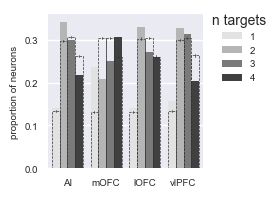

In [18]:
# 4C

ai1 = np.ones(57)
ai2 = np.ones(139) * 2
ai3 = np.ones(122) * 3
ai4 = np.ones(88) * 4

ai = np.hstack((ai1,ai2,ai3,ai4))
ai = pd.DataFrame(ai,columns=['targets'])
ai = ai.assign(area='AI')
del ai1, ai2, ai3, ai4

mo1 = np.ones(17)
mo2 = np.ones(15) * 2
mo3 = np.ones(18) * 3
mo4 = np.ones(22) * 4

mo = np.hstack((mo1,mo2,mo3,mo4))
mo = pd.DataFrame(mo,columns=['targets'])
mo = mo.assign(area='mOFC')
del mo1, mo2, mo3, mo4

lo1 = np.ones(12)
lo2 = np.ones(28) * 2
lo3 = np.ones(23) * 3
lo4 = np.ones(22) * 4

lo = np.hstack((lo1,lo2,lo3,lo4))
lo = pd.DataFrame(lo,columns=['targets'])
lo = lo.assign(area='lOFC')
del lo1, lo2, lo3, lo4

vl1 = np.ones(10)
vl2 = np.ones(21) * 2
vl3 = np.ones(20) * 3
vl4 = np.ones(13) * 4

vl = np.hstack((vl1,vl2,vl3,vl4))
vl = pd.DataFrame(vl,columns=['targets'])
vl = vl.assign(area='vlPFC')
del vl1, vl2, vl3, vl4

all_ofc = pd.concat((ai,mo,lo,vl))

#%%

iter_res = []

for iter in range(1000):
    
	down_ofc = pd.concat((all_ofc[all_ofc.area=='AI'].sample(64,replace=False,random_state=1),all_ofc[all_ofc.area=='mOFC'].sample(64,replace=False,random_state=1),all_ofc[all_ofc.area=='lOFC'].sample(64,replace=False,random_state=1),all_ofc[all_ofc.area=='vlPFC'].sample(64,replace=False,random_state=1)))
    
	shuf_ofc = down_ofc.assign(area2 = rng.permutation(down_ofc.area.to_numpy()))

	for area in shuf_ofc.area2.unique():
		
		this_area = shuf_ofc[shuf_ofc.area2==area]
		
		for target in [1,2,3,4]:
			
			this_target = this_area[this_area.targets==target]
			
			iter_res.append((area,target,len(this_target),len(this_target)/len(this_area)))
   
res_ofc = pd.DataFrame(iter_res,columns=['area','ntargets','count','prop'])
   
iter_res_ofc = res_ofc.groupby(['area','ntargets'],as_index=False).mean()

#%%

real_res = []

for area in all_ofc.area.unique():
	
	this_area = all_ofc[all_ofc.area==area]
	
	for target in [1,2,3,4]:
		
		this_target = this_area[this_area.targets==target]
		
		real_res.append((area,target,len(this_target),len(this_target)/len(this_area)))
  
real_res_ofc = pd.DataFrame(real_res,columns=['area','ntargets','count','prop'])

plt.figure(figsize=(2,2))

g=sns.barplot(data=real_res_ofc,x='area',y='prop',hue='ntargets',order=['AI','mOFC','lOFC','vlPFC'],palette='Greys')
h=sns.barplot(data=res_ofc,x='area',y='prop',hue='ntargets',ci=95,order=['AI','mOFC','lOFC','vlPFC'],facecolor=(1,1,1,0),linewidth=0.5,edgecolor="0.2",errcolor='0.2',errwidth=0.5,linestyle='dashed')

plt.ylabel('proportion of neurons',fontsize=7)
plt.xlabel('')

plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

hand, labl = g.get_legend_handles_labels()
plt.legend(hand[0:4],labl[0:4],title='n targets',fontsize=7,loc='lower left',bbox_to_anchor=(1.0,0.5))

# plt.savefig('Fig4C.pdf')

plt.show()

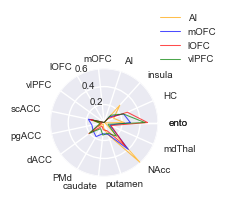

In [19]:
proj_to_mofc = []
proj_to_mofc_ = []

for neuron in range(len(no_control)):
    
    if all_combined[neuron,5] == 1 and all_combined[neuron,6] == 0 and all_combined[neuron,7] == 0 and all_combined[neuron,4] == 0:
        
        proj_to_mofc.append(no_control[neuron,:])

proj_to_lofc = []
proj_to_lofc_ = []

for neuron in range(len(no_control)):
    
    if all_combined[neuron,5] == 0 and all_combined[neuron,6] == 1 and all_combined[neuron,7] == 0 and all_combined[neuron,4] == 0:
        
        proj_to_lofc.append(no_control[neuron,:])
        
proj_to_vlpfc = []
proj_to_vlpfc_ = []

for neuron in range(len(no_control)):
    
    if all_combined[neuron,5] == 0 and all_combined[neuron,6] == 0 and all_combined[neuron,7] == 1 and all_combined[neuron,4] == 0:
        
        proj_to_vlpfc.append(no_control[neuron,:])
                
proj_to_ai = []
proj_to_ai_ = []

for neuron in range(len(no_control)):
    
    if all_combined[neuron,5] == 0 and all_combined[neuron,6] == 0 and all_combined[neuron,7] == 0 and all_combined[neuron,4] == 1:
        
        proj_to_ai.append(no_control[neuron,:])
                
props = np.sum(proj_to_mofc,axis=0) / len(proj_to_mofc)

props = props[1:] #remove amygdala

props1 = np.append(props,props[0])

theta = np.linspace(0,1,num=16)

theta = theta * 2 * np.pi

props = np.sum(proj_to_lofc,axis=0) / len(proj_to_lofc)

props = props[1:] #remove amygdala

props2 = np.append(props,props[0])

theta = np.linspace(0,1,num=16)

theta = theta * 2 * np.pi

props = np.sum(proj_to_vlpfc,axis=0) / len(proj_to_vlpfc)

props = props[1:] #remove amygdala

props3 = np.append(props,props[0])

theta = np.linspace(0,1,num=16)

theta = theta * 2 * np.pi

props = np.sum(proj_to_ai,axis=0) / len(proj_to_ai)

props = props[1:] #remove amygdala

props4 = np.append(props,props[0])

theta = np.linspace(0,1,num=16)

theta = theta * 2 * np.pi

props1 = np.where(props1 >= np.max(props1), 0, props1)
props2 = np.where(props2 >= np.max(props2), 0, props2)
props3 = np.where(props3 >= np.max(props3), 0, props3)
props4 = np.where(props4 >= np.max(props4), 0, props4)

# make central polar plot

fig,ax = plt.subplots(figsize=(1.4,1.4),subplot_kw={'projection':'polar'})

ax.plot(theta,props4,color='orange',label='AI',alpha=0.7,linewidth=0.75)
ax.plot(theta,props1,color='blue',label='mOFC',alpha=0.7,linewidth=0.75)
ax.plot(theta,props2,color='red',label='lOFC',alpha=0.7,linewidth=0.75)
ax.plot(theta,props3,color='green',label='vlPFC',alpha=0.7,linewidth=0.75)

ax.set_rlabel_position(115.5)
ax.set_rgrids([0.2,0.4,0.6],fontsize=7,ha='center')
ax.set_rlim(0,0.6)

ax.set_xticks(theta)
labels = ax.set_xticklabels(areas4 + ['ento'],fontsize=7)
ax.xaxis.set_tick_params(pad=0.5)

for i, label in enumerate(labels):
    if i in [0,1,2,3,13,14,15,16,17]:
        label.set_horizontalalignment('left')
    elif i in [5,6,7,8,9,10,11]:
        label.set_horizontalalignment('right')
    elif i in [4,12]:
        label.set_horizontalalignment('center')
        
angle = np.deg2rad(67.5)
ax.legend(loc="lower left",
          bbox_to_anchor=(0.75 + np.cos(angle)/2, .5 + np.sin(angle)/2),fontsize=7)

# plt.savefig('Fig4F.pdf')

plt.show()

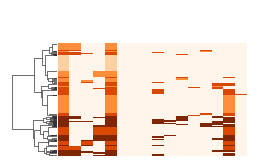

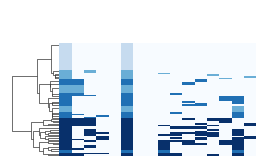

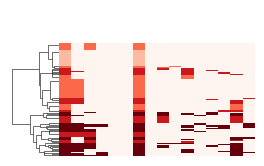

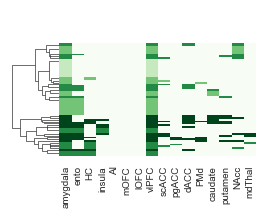

In [20]:
# 4E

proj_to_mofc = np.array(proj_to_mofc)

mofc_specific = []
mofc_2targ = []
mofc_3targ = []
mofc_4plus = []

for neuron in range(len(proj_to_mofc)):
        
    if np.sum(proj_to_mofc[neuron,1:]) == 1:
        
        mofc_specific.append(proj_to_mofc[neuron,:])
        
    elif np.sum(proj_to_mofc[neuron,1:]) == 2:
        
        mofc_2targ.append(proj_to_mofc[neuron,:])
        
    elif np.sum(proj_to_mofc[neuron,1:]) == 3:
        
        mofc_3targ.append(proj_to_mofc[neuron,:])
        
    elif np.sum(proj_to_mofc[neuron,1:]) >= 4:
        
        mofc_4plus.append(proj_to_mofc[neuron,:])
        
mofc_specific = np.array(mofc_specific)
mofc_2targ = np.array(mofc_2targ)
mofc_3targ = np.array(mofc_3targ)
mofc_4plus = np.array(mofc_4plus)
        
mofc_by_target = np.vstack((mofc_specific,mofc_2targ*2,mofc_3targ*3,mofc_4plus*4))


proj_to_lofc = np.array(proj_to_lofc)

lofc_specific = []
lofc_2targ = []
lofc_3targ = []
lofc_4plus = []

for neuron in range(len(proj_to_lofc)):
        
    if np.sum(proj_to_lofc[neuron,1:]) == 1:
        
        lofc_specific.append(proj_to_lofc[neuron,:])
        
    elif np.sum(proj_to_lofc[neuron,1:]) == 2:
        
        lofc_2targ.append(proj_to_lofc[neuron,:])
        
    elif np.sum(proj_to_lofc[neuron,1:]) == 3:
        
        lofc_3targ.append(proj_to_lofc[neuron,:])
        
    elif np.sum(proj_to_lofc[neuron,1:]) >= 4:
        
        lofc_4plus.append(proj_to_lofc[neuron,:])
        
lofc_specific = np.array(lofc_specific)
lofc_2targ = np.array(lofc_2targ)
lofc_3targ = np.array(lofc_3targ)
lofc_4plus = np.array(lofc_4plus)

lofc_by_target = np.vstack((lofc_specific,lofc_2targ*2,lofc_3targ*3,lofc_4plus*4))


proj_to_vlpfc = np.array(proj_to_vlpfc)

vlpfc_specific = []
vlpfc_2targ = []
vlpfc_3targ = []
vlpfc_4plus = []

for neuron in range(len(proj_to_vlpfc)):
        
    if np.sum(proj_to_vlpfc[neuron,1:]) == 1:
        
        vlpfc_specific.append(proj_to_vlpfc[neuron,:])
        
    elif np.sum(proj_to_vlpfc[neuron,1:]) == 2:
        
        vlpfc_2targ.append(proj_to_vlpfc[neuron,:])
        
    elif np.sum(proj_to_vlpfc[neuron,1:]) == 3:
        
        vlpfc_3targ.append(proj_to_vlpfc[neuron,:])
        
    elif np.sum(proj_to_vlpfc[neuron,1:]) >= 4:
        
        vlpfc_4plus.append(proj_to_vlpfc[neuron,:])
        
vlpfc_specific = np.array(vlpfc_specific)
vlpfc_2targ = np.array(vlpfc_2targ)
vlpfc_3targ = np.array(vlpfc_3targ)
vlpfc_4plus = np.array(vlpfc_4plus)

vlpfc_by_target = np.vstack((vlpfc_specific,vlpfc_2targ*2,vlpfc_3targ*3,vlpfc_4plus*4))
        
        
proj_to_ai = np.array(proj_to_ai)

ai_specific = []
ai_2targ = []
ai_3targ = []
ai_4plus = []

for neuron in range(len(proj_to_ai)):
        
    if np.sum(proj_to_ai[neuron,1:]) == 1:
        
        ai_specific.append(proj_to_ai[neuron,:])
        
    elif np.sum(proj_to_ai[neuron,1:]) == 2:
        
        ai_2targ.append(proj_to_ai[neuron,:])
        
    elif np.sum(proj_to_ai[neuron,1:]) == 3:
        
        ai_3targ.append(proj_to_ai[neuron,:])
        
    elif np.sum(proj_to_ai[neuron,1:]) >= 4:
        
        ai_4plus.append(proj_to_ai[neuron,:])
        
ai_specific = np.array(ai_specific)
ai_2targ = np.array(ai_2targ)
ai_3targ = np.array(ai_3targ)
ai_4plus = np.array(ai_4plus)

ai_by_target = np.vstack((ai_specific,ai_2targ*2,ai_3targ*3,ai_4plus*4))

g = sns.clustermap(data=ai_by_target,cmap='Oranges',method='ward',col_cluster=False,figsize=(3,2))

g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticklabels([])

g.cax.set_visible(False)

# plt.savefig('Fig4E1.pdf')

plt.show()

g = sns.clustermap(data=mofc_by_target,cmap='Blues',method='ward',col_cluster=False,figsize=(3,2))

g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticklabels([])

g.cax.set_visible(False)

# plt.savefig('Fig4E2.pdf')

plt.show()

g = sns.clustermap(data=lofc_by_target,cmap='Reds',method='ward',col_cluster=False,figsize=(3,2))

g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticklabels([])

g.cax.set_visible(False)

# plt.savefig('Fig4E3.pdf')

plt.show()

g = sns.clustermap(data=vlpfc_by_target,cmap='Greens',method='ward',col_cluster=False,figsize=(3,2))

g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticklabels([])

g.ax_heatmap.set_xticks(np.array(range(16))+0.5)
g.ax_heatmap.set_xticklabels(areas3,rotation=90,fontsize=7)

g.cax.set_visible(False)

# plt.savefig('Fig4E4.pdf')

plt.show()

# Figure 5
Retro-AAV tract-tracing and stereology

In [21]:
# Import data

left = []
left.append(('NAcc',217,271885.78))
left.append(('AI',44,55128.91))
left.append(('Both',45,56381.84))

left = pd.DataFrame(left,columns=['area','count','all_count'])

right = []
right.append(('vlPFC',9,8404.5))
right.append(('OFC',52,48559.32))
right.append(('both',51,47625.48))

right = pd.DataFrame(right,columns=['area','count','all_count'])

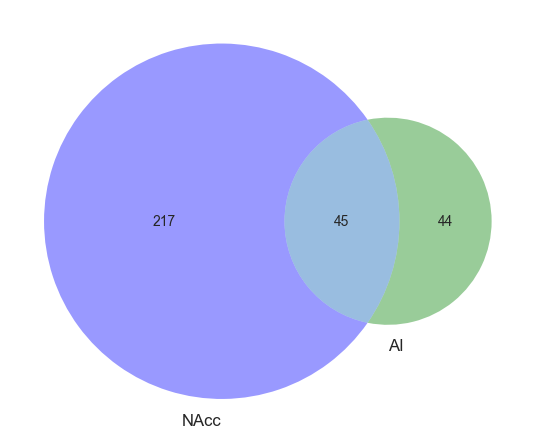

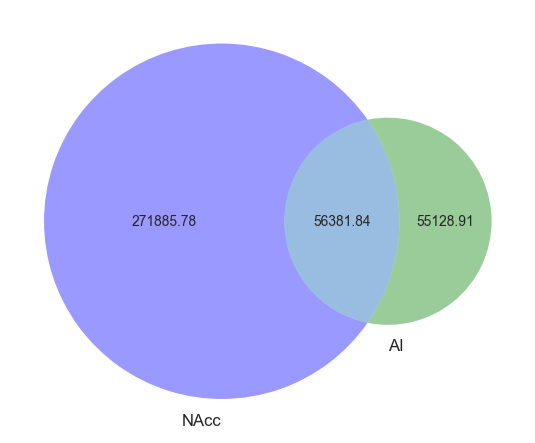

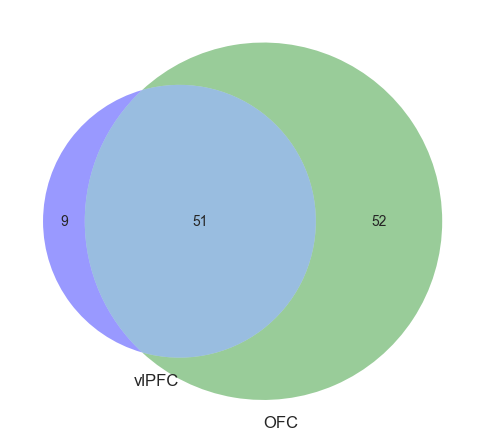

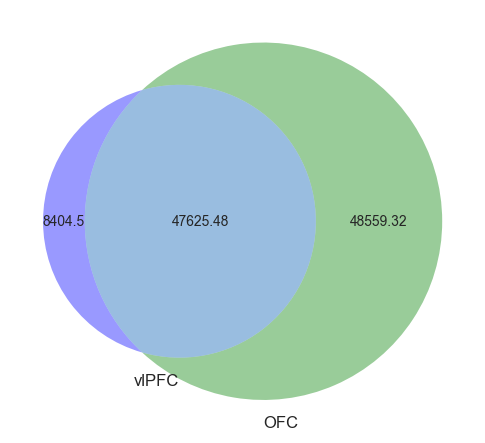

In [22]:
# Venn diagrams of overlapping projection

venn2(left['count'].to_numpy(),set_labels=['NAcc','AI'],set_colors=['blue','green'])

plt.show()

venn2(left['all_count'].to_numpy(),set_labels=['NAcc','AI'],set_colors=['blue','green'])

plt.show()

venn2(right['count'].to_numpy(),set_labels=['vlPFC','OFC'],set_colors=['blue','green'])

plt.show()

venn2(right['all_count'].to_numpy(),set_labels=['vlPFC','OFC'],set_colors=['blue','green'])

plt.show()

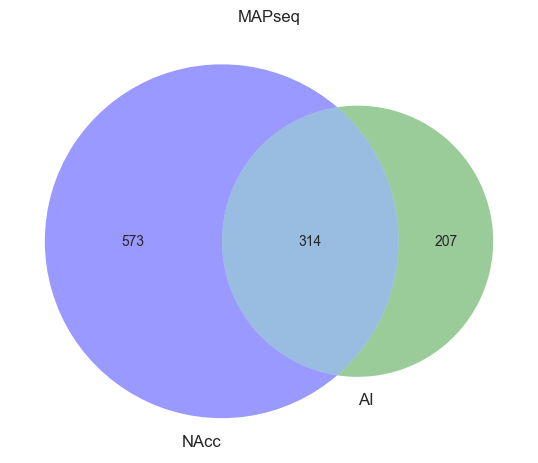

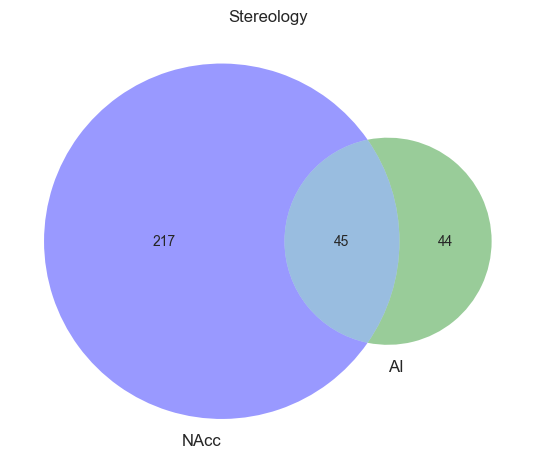

In [23]:
# Comparison to MAPseq results

# nacc (14) vs ai (5)

proj_to_nacc = []
proj_to_ai = []
proj_to_both = []

for neuron in range(len(all_combined)):
    
    if all_combined[neuron,4] == 0 and all_combined[neuron,14] == 1:
        
        proj_to_nacc.append(all_combined[neuron,:])
        
    elif all_combined[neuron,4] == 1 and all_combined[neuron,14] == 0:
        
        proj_to_ai.append(all_combined[neuron,:])
        
    elif all_combined[neuron,4] == 1 and all_combined[neuron,14] == 1:
        
        proj_to_both.append(all_combined[neuron,:])

venn2([len(proj_to_nacc),len(proj_to_ai),len(proj_to_both)],set_labels=['NAcc','AI'],set_colors=['blue','green'])
plt.title('MAPseq')
plt.show()

venn2(left['count'].to_numpy(),set_labels=['NAcc','AI'],set_colors=['blue','green'])
plt.title("Stereology")
plt.show()

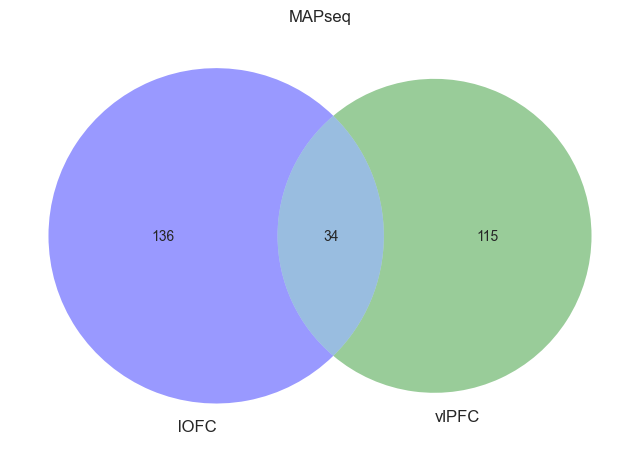

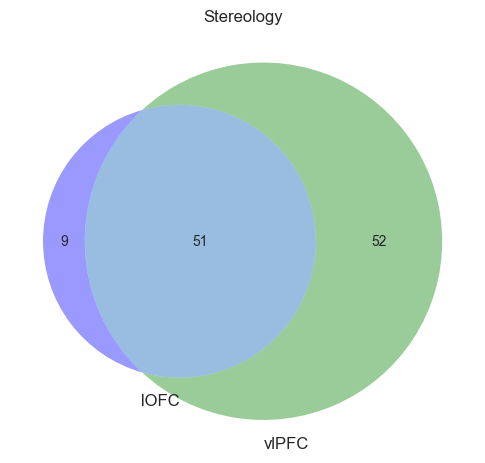

In [24]:
# Repeat for OFC and vlPFC

# ofc (6) vs vlpfc (7)

areas = ['amygdala','ento','HC','insula','AI','mOFC','lOFC','vlPFC','scACC','pgACC','dACC','PMd','caudate','putamen','NAcc','mdThal']


proj_to_ofc = []
proj_to_vlpfc = []
proj_to_both2 = []

for neuron in range(len(all_combined)):
    
    if all_combined[neuron,6] == 1 and all_combined[neuron,7] == 0:
        
        proj_to_ofc.append(all_combined[neuron,:])
        
    elif all_combined[neuron,6] == 0 and all_combined[neuron,7] == 1:
        
        proj_to_vlpfc.append(all_combined[neuron,:])
        
    elif all_combined[neuron,6] == 1 and all_combined[neuron,7] == 1:
        
        proj_to_both2.append(all_combined[neuron,:])
        
venn2([len(proj_to_ofc),len(proj_to_vlpfc),len(proj_to_both2)],set_labels=['lOFC','vlPFC'],set_colors=['blue','green'])
plt.title('MAPseq')
plt.show()

venn2(right['count'].to_numpy(),set_labels=['lOFC','vlPFC'],set_colors=['blue','green'])
plt.title("Stereology")
plt.show()